In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Trip start and end dates
trip_start_date = '2017-10-01'
trip_end_date = '2017-10-15'

In [23]:
# Calculate today's date
today_date = str(dt.datetime.now().date())

# Due to avaialbe data explicity setting date
today_date = '2018-01-01'
today_date

'2018-01-01'

In [24]:
def calcYearAgoDate(current_date):
    year_ago_date = dt.datetime.strptime(current_date, '%Y-%m-%d') - dt.timedelta(days=365);
    return dt.datetime.strftime(year_ago_date,'%Y-%m-%d')

# Calculate the date 1 year ago from today
year_ago_date = calcYearAgoDate(today_date)

# Due to avaialbe data explicity setting date
year_ago_date = '2017-01-01'
year_ago_date

'2017-01-01'

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# prcp_data

prcp_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= year_ago_date).filter(Measurement.date <= today_date).all()

In [26]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index("date")
prcp_df = prcp_df.sort_values("date",ascending=True)
prcp_df.head()


,prcp
date,
2017-01-01,0.00
2017-01-01,0.00
2017-01-01,0.03
2017-01-01,0.03
2017-01-01,0.29


<IPython.core.display.Javascript object>


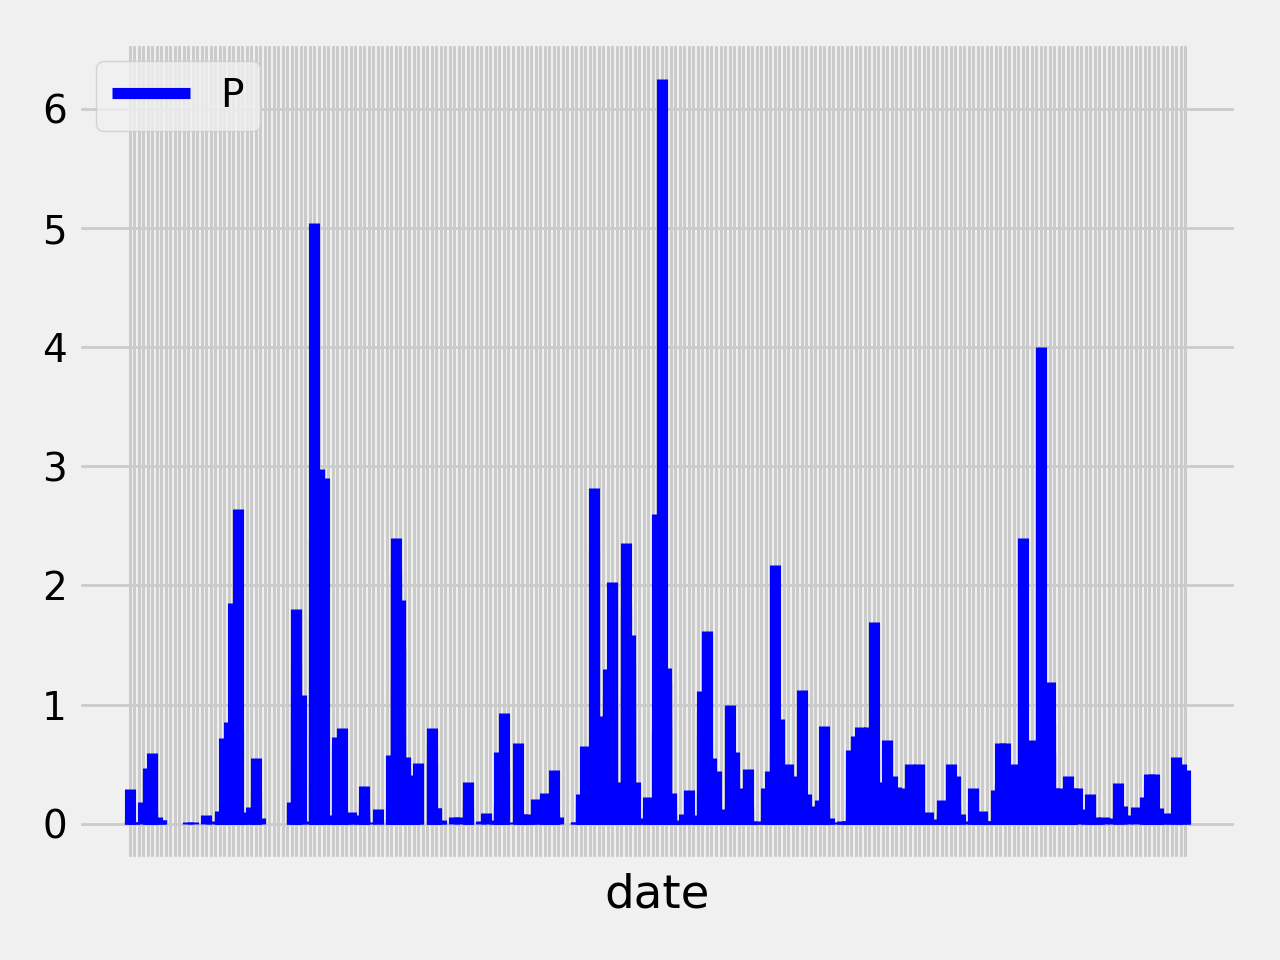

In [27]:
fig, ax  = plt.subplots()


# Add the grid
ax.grid(which='major', axis='y', linestyle='-')
x = prcp_df.index.values
y = prcp_df["prcp"]
ax = plt.vlines(x, [0], y, colors='b', linestyles='solid', label='', )

plt.xticks(x, rotation="45")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("date")
plt.legend("Precipitation",loc=2)
plt.grid(True)
fig.tight_layout()
plt.show()


In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df[['prcp']].describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


In [36]:
# How many stations are available in this dataset?
station_data = session.query(Station.id, Station.station).all()
[len(station_data)]

[9]

In [37]:
# Station and count list
station_count = engine.execute(
    "SELECT station, count(station) FROM measurement GROUP BY station ORDER BY count(station) DESC").fetchall()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations_sorted = pd.DataFrame(data=active_stations, columns=['Station', 'Count'])
active_stations_sorted

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [48]:
# Listing most active station
most_active_station = active_stations_sorted["Station"][0]
most_active_station

'USC00519281'

In [49]:
# What are the most active stations?
print("Most active stations are 'USC00519281','USC00519397' and 'USC00513117'")

Most active stations are 'USC00519281','USC00519397' and 'USC00513117'


In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_max_avg_temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').all()
min_max_avg_temp

[(54.0, 71.66378066378067, 85.0)]

In [51]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = "SELECT station, tobs FROM measurement WHERE station IN\
 (SELECT station FROM measurement GROUP BY station ORDER BY COUNT(tobs) DESC LIMIT 1)\
 AND date BETWEEN '" + year_ago_date + "' AND '" + today_date + "'"

query

"SELECT station, tobs FROM measurement WHERE station IN (SELECT station FROM measurement GROUP BY station ORDER BY COUNT(tobs) DESC LIMIT 1) AND date BETWEEN '2017-01-01' AND '2018-01-01'"

In [52]:
station_histogram = engine.execute(query).fetchall()
station_histogram_df = pd.DataFrame(station_histogram)
station_histogram_df.head()

,0,1
0,USC00519281,72.0
1,USC00519281,70.0
2,USC00519281,64.0
3,USC00519281,63.0
4,USC00519281,63.0


<IPython.core.display.Javascript object>


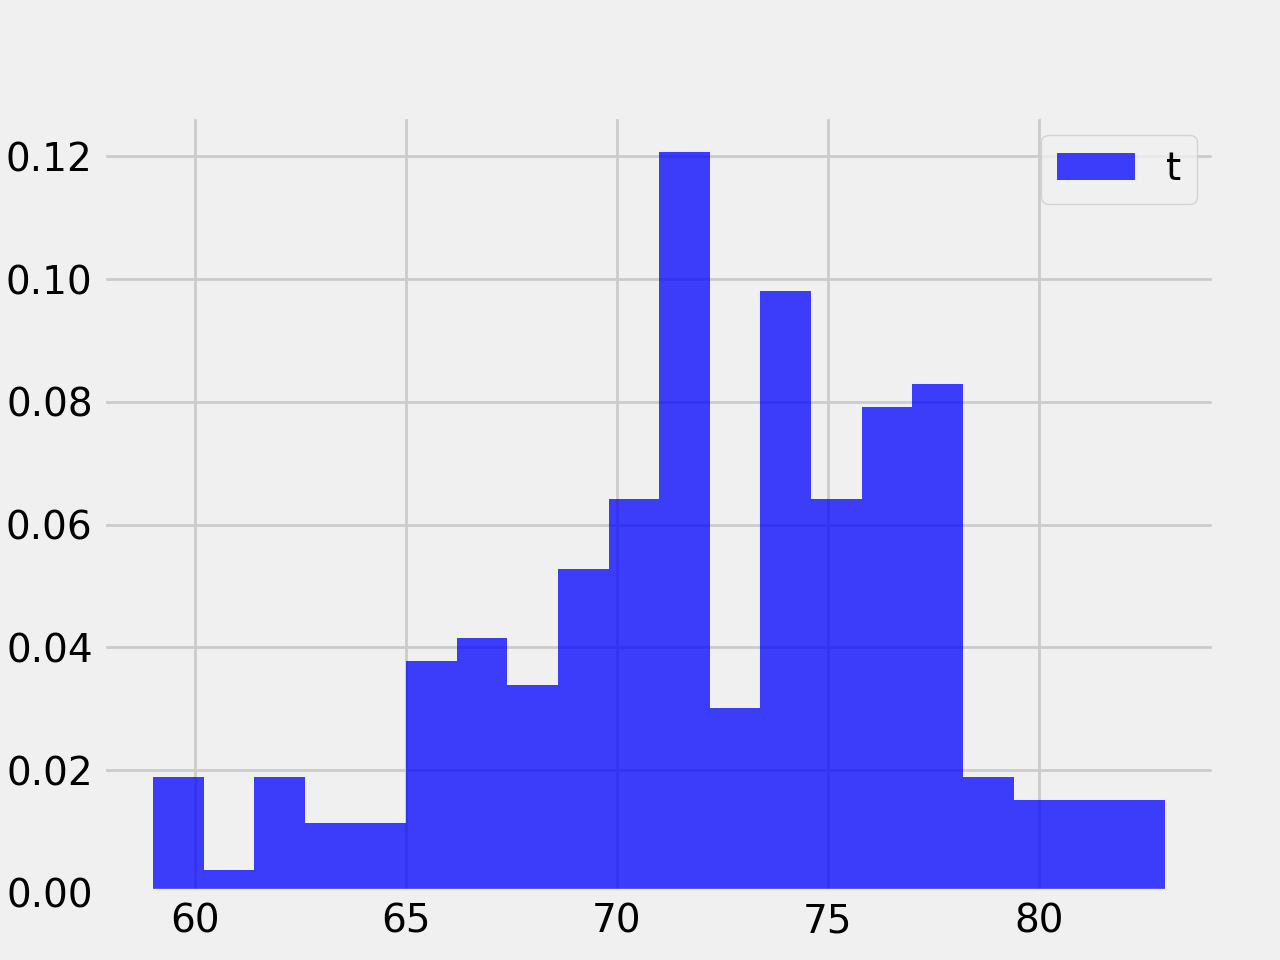

In [58]:
fig, ax  = plt.subplots()
x = station_histogram_df[1]
n, bins, patches = plt.hist(x, 20, density=True, 
                            facecolor='b', alpha=0.75, rwidth=100)
plt.legend('tobs')
plt.grid(True)
plt.show()

In [54]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = calcYearAgoDate(trip_start_date)
end_date = calcYearAgoDate(trip_end_date)
temp_results = calc_temps(start_date, end_date)
temp_results

[(71.0, 77.78947368421052, 82.0)]

<IPython.core.display.Javascript object>


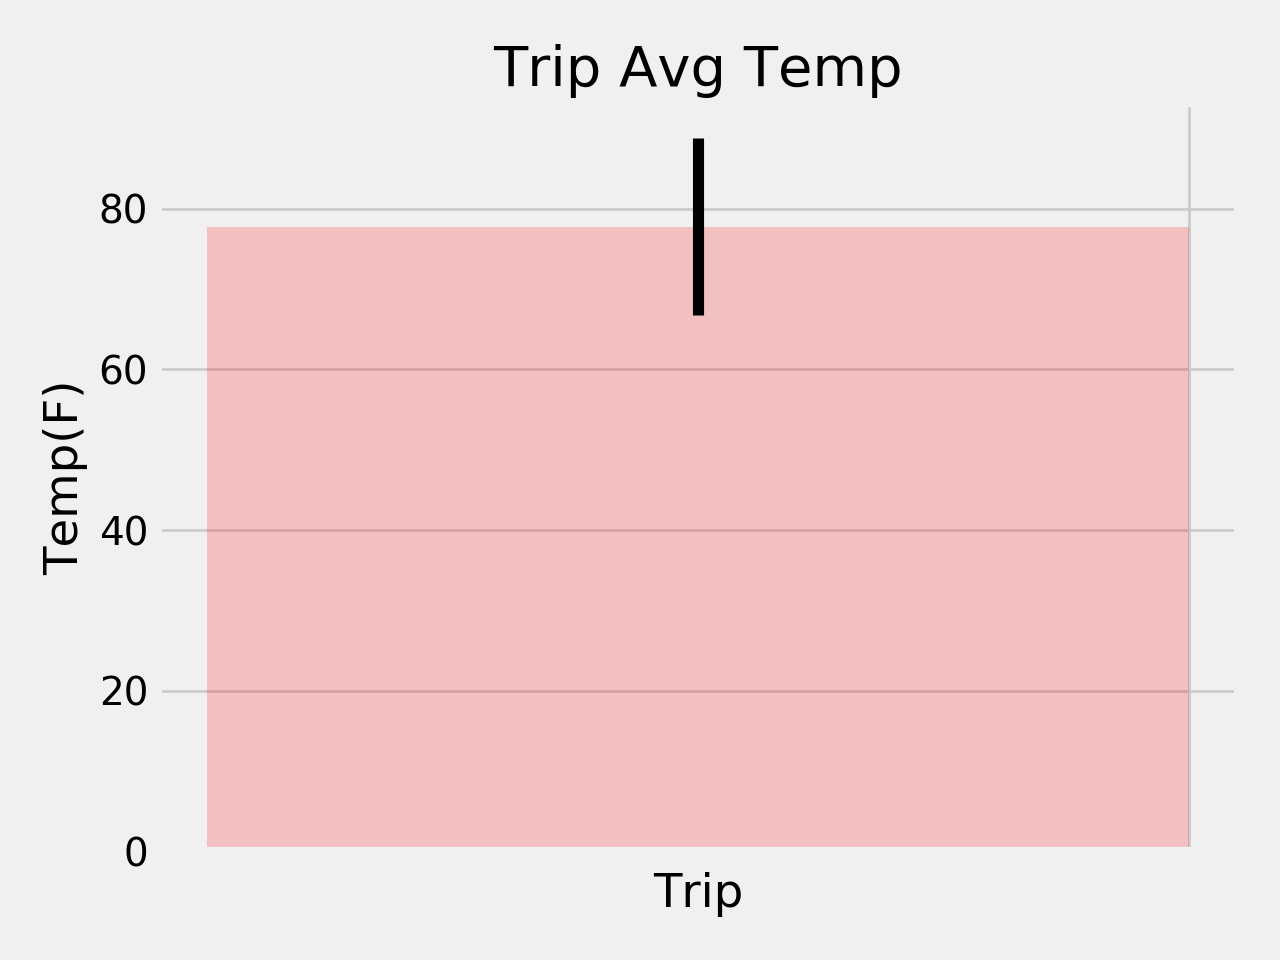

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
bar_width = 0.5
opacity = 0.2
n_groups = 1
mean_temp = (temp_results[0][1])
std_temp = (temp_results[0][2]-temp_results[0][0])
index = np.arange(n_groups)
rects1 = ax.bar(index, mean_temp, bar_width,
                alpha=opacity, color='r',
                yerr=std_temp)
ax.set_xlabel('Trip')
ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((''))
fig.tight_layout()
plt.show()
